In [1]:
import sys
import os
from pathlib import Path

# importディレクトリの追加
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
print(sys.path)

# プロキシの設定
# os.environ['HTTP_PROXY'] = ''
# os.environ['HTTPS_PROXY'] = ''

%matplotlib inline

['/home/y-katayama/notebooks/dl_study/02_pytorch_tutorial', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/y-katayama/venv/pt1.7/lib/python3.8/site-packages']


In [2]:
!nvidia-smi

Fri Dec 16 13:58:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 40%   33C    P8    17W / 184W |     47MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:03:00.0 Off |                  N/A |
| 40%   

- PytorchはTensorBoardと連携しているので, 可視化ツールとして利用することができる

- このチュートリアルでは以下の5項目について記載する
    1. データを読み込み、適切な変換を実施（前回のチュートリアルとほぼ同じ内容）
    1. TensorBoardのセットアップ
    1. TensorBoardへの書き込み
    1. TensorBoardによるモデル構造の解析
    1. TensorBoardを用いて、前回のチュートリアルよりも少ないコードで、インタラクティブ（対話的）な結果の表示を実現

In [3]:
"""
# Google ColabでTensorboardを使うための設定
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  print("エラー、やり直してください")
  pass
"""

'\n# Google ColabでTensorboardを使うための設定\nfrom __future__ import absolute_import, division, print_function, unicode_literals\n\ntry:\n  # %tensorflow_version only exists in Colab.\n  %tensorflow_version 2.x\nexcept Exception:\n  print("エラー、やり直してください")\n  pass\n'

In [4]:
%load_ext tensorboard

# モデルの定義

- CIFAR-10チュートリアルとほぼ同じ

- Fashion-MNISTを使用するため, モデルに以下の変更を加える
    - 画像のカラーチャネルが3チャネルではなく1チャネ
    - サイズが32x32から28x28になっている

In [5]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 1. TensorBoardのセットアップ

- torch.utilsからtensorboardをimportする
- tensorboardに情報を書き込むためのSummarywriterを作成する

In [7]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

2022-12-16 13:58:16.492226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 13:58:16.978968: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-16 13:58:16.979013: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-16 13:58:16.979019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# 2. TensorBoardに書き込む

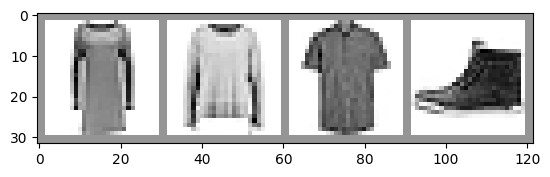

In [8]:
# データローダから適当な画像を読み込む
dataiter = iter(trainloader)
images, labels = dataiter.next()

# イメージグリッドを作成
img_grid = torchvision.utils.make_grid(images)

# 画像を表示する
matplotlib_imshow(img_grid, one_channel=True)

# TensorBoardに書き込む
writer.add_image('four_fashion_mnist_images', img_grid)

In [9]:
# pip3でtensorboardをインストールするだけでは動かなかった
# tensorboard --logdir=runs

# pip3 tf-nightlyをインストールして, magicコマンド以下に変更すると動いた
# %tensorboard  --logdir runs --host 0.0.0.0 --port 6006

# 3.TensorBoardを使用してモデルを詳しく調べる

- TensorBoardでは複雑なモデル構造を可視化できる
- 以下のコードを実行して, TensorBoardを再度読み込むとGraphsタブが出現する
- モデルNetを構成する個別の処理を確認することができる

In [10]:
writer.add_graph(net, images)
writer.close()

In [11]:
# 4. TensorBoardに"Project"を追加する

In [12]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [13]:
# helper function
#def select_n_random(data, labels, n=500):  # 日本語訳注：500は多いので減らす
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [14]:
%tensorboard  --logdir runs/fashion_mnist_experiment_1 --host 0.0.0.0 --port 6006

# 5. TensorBoardでモデルの訓練課程を解析する

In [15]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    
    # np.squeeze()は次元を一つ減らす
    preds = np.squeeze(preds_tensor.numpy())
    # nnの出力(logit)をsoftmax関数に入力し, 信頼度がもっとも大きいクラスの信頼度の集合を返す
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [16]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            
            # TensorBoardにtraining lossの値を出力する
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            
            # tensorboardにtest時の予測結果を出力する
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training
